In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')

In [3]:
len(df)

11914

In [4]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [5]:
# Lowercase all the column names and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Select only columns with string values
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

# Lowercase and replace spaces with underscores for values in all string columns of the dataframe
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [6]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


This dataset contains multiple columns:    
- make -- make of a car (BMW, Toyota, and so on)
- model -- model of a car
- year -- year when the car was manifactured
- engine_fuel_type -- type of the fuel the engine needs (diesel, electric and so on)
- engine_hp -- horsepower of the engine
- engine_cylinders -- number of cylinders in the engine
- transmission_type -- type of transmission (automatic or manuel)
- driven_wheels -- front, rear, all
- number of doors -- number of doors a car has
- market_category -- luxury, crossover, and so on
- vehicle_size -- compact, midsize, or large
- vehicle_style -- sedan or convertible
- highway_mpg -- miles per gallon (mpg) on the highway
- city_mpg -- miles per gallon in the city
- popularity -- number of times the car was mentioned in Twitter stream
- msrp -- manufacturer's suggested retail price

### Target variable analysis

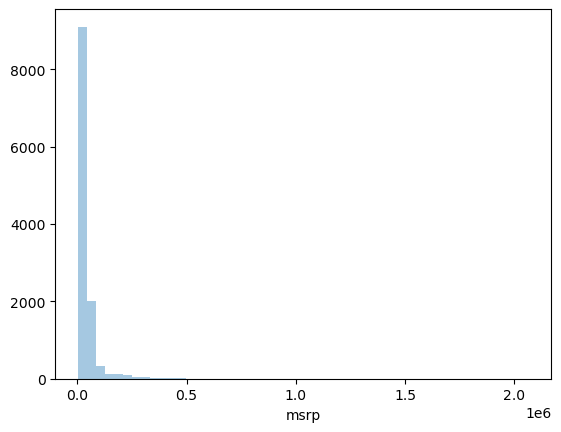

In [7]:
sns.distplot(df.msrp, kde=False)

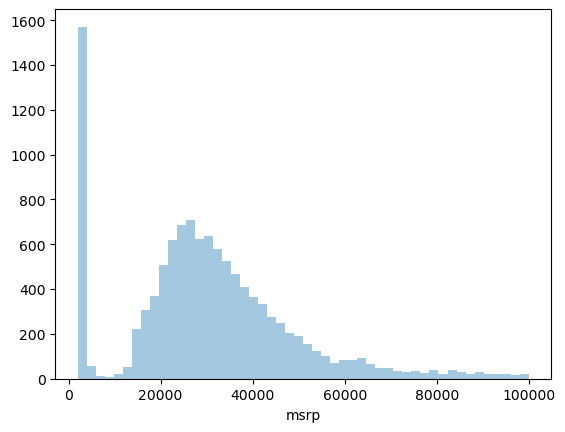

In [8]:
# To have a closer look 
sns.distplot(df.msrp[df.msrp < 100_000], kde=False)

In [26]:
# Transforming the data using BoxCox
fitted_price, fitted_lambda = sp.stats.boxcox(df.msrp)

lambda: 0.214


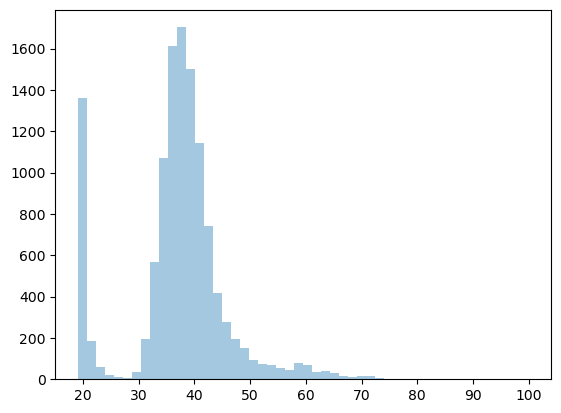

In [10]:
print("lambda: {:.3f}".format(fitted_lambda))

sns.distplot(fitted_price, kde=False)

### Checking the missing values

In [11]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

### Validation framework

In [12]:
# 20% of the data goes to validation
# 20% goes to test
# and the remaining 60% goes to train
n = len(df)

# Calculate how many rows should go ti train, validation and test
n_val = int(0.2 * n)
n_test = int(0.2 *n)
n_train = n - (n_val + n_test)

# Create a NumPy array with indices from 0 to (n-1) and shuffle it
np.random.seed(2) # Fix the random seed to make sure that the results are reproducible
idx = np.arange(n)
np.random.shuffle(idx)

# Use the array with idx to get a shuffle dataframe
df_shuffled = df.iloc[idx]

# Split the shuffles dataframe into train, validation and test
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [13]:
# Transforming the target using BoxCox for each dataframe
y_train = sp.stats.boxcox(df_train.msrp.values, lmbda=fitted_lambda)
y_val = sp.stats.boxcox(df_val.msrp.values, lmbda=fitted_lambda)
y_test = sp.stats.boxcox(df_test.msrp.values, lmbda=fitted_lambda)

In [14]:
# To avoid accidentally using the target later
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

### Linear regression

I'll implement the linear regression myself for this model

In [15]:
def linear_regression(X, y):
    """Linear regression implemented with numpy"""
    # Adding the dummy column
    ones = np.ones(X.shape[0])      # Create an array that contains only 1s
    X = np.column_stack([ones, X])  # Add the array of 1s as the first column of X

    # Normal equation formula
    XTX = X.T.dot(X)                # Compute XtX
    XTX_inv = np.linalg.inv(XTX)    # Compute the inverse of XtX
    w = XTX_inv.dot(X.T).dot(y)     # Compute the rest of the normal equation

    return w[0], w[1:]              # Split the weights vector into the bias and the rest of the weights

Let's start with some quantitative features

- engine_hp
- engine_cylinders
- highway_mpg
- city_mpg
- popularity

In [16]:
# Select the features from the data frame 
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
df_num = df_train[base]

In [17]:
# Let's deal with the missing values the simplest way
df_num = df_num.fillna(0)

In [18]:
X_train = df_num.values
w_0, w = linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)

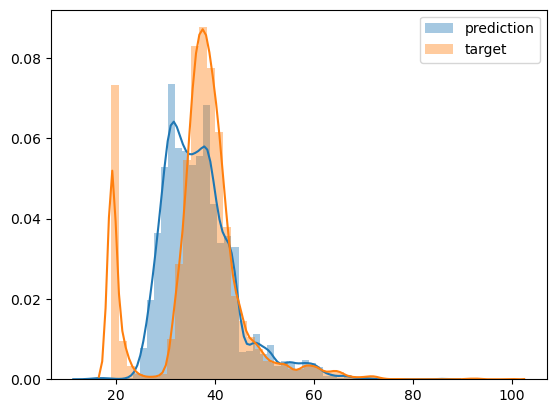

In [19]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='target')
plt.legend()

In [20]:
# The implementation of RMSE
def rmse(y, y_pred):
    error = y_pred - y                  # The difference between the predicted and the target
    mse = (error ** 2).mean()           # Compute MSE
    return np.sqrt(mse)

In [21]:
def prepare_X(df, base=base):
    """A function for converting a dataframe into a matrix"""
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [22]:
# Train the model
X_train = prepare_X(df_train)
w_0, w = linear_regression(X_train, y_train)

# Apply the model to the validation test
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
# compute the rmse on the validation data
print('validation:', rmse(y_val, y_pred))

validation: 5.655567673464045


### Simple feature engineering

In [23]:
def prepare_X(df, base=base):
    """Creating the 'age' feature in the prepare_X function"""
    df = df.copy()              # Create a copy of the input parameter to prevent side effects
    features = base.copy()      # Create a copy of the base list with the basic features

    # Compute the age feature
    df['age'] = 2017 - df.year  # The data was created in 2017
    features.append('age')      # Append age to the list of features names we used for the model

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [24]:
X_train = prepare_X(df_train)
w_0, w = linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

validation: 4.2760047269008785


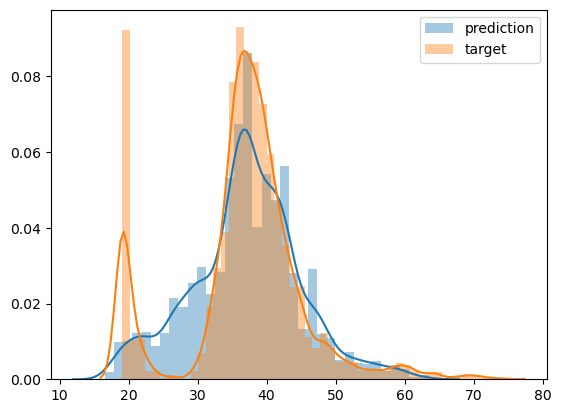

In [27]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_val, label='target')
plt.legend()

### Handling categorical variables

In [31]:
def prepare_X(df):
    """Handling categorical variables 'number of doors' and 'make' in the prepare_X function"""
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    # Encode the number of doors variable
    for v in [2, 3, 4]:     # Iterate over possible values of "number of doors" variable
        feature = 'num_doors_%s' % v        # Give a feature meaningful name
        df[feature] = (df['number_of_doors'] == v).astype(int)      # Create the one-hot encoding feature
        features.append(feature)

    # Encode the make variable (I'll take only the most frequent values)
    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [32]:
X_train = prepare_X(df_train)
w_0, w = linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

validation: 4.159242675263762


In [ ]:
df['engine_fuel_type'].value_counts()

In [ ]:
df['transmission_type'].value_counts()

In [ ]:
df['driven_wheels'].value_counts()

In [ ]:
df['market_category'].value_counts().head(5)

In [ ]:
df['vehicle_size'].value_counts().head(5)

In [ ]:
df['vehicle_style'].value_counts().head(5)

Let's make the function prepare_X handle more variables

In [37]:
def prepare_X(df):
    """Handling more categorical variables"""
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    # Encode the type variable
    for v in ['regular_unleaded', 'premium_unleaded_(required)', 'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)']:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)

    # Encode the transmission variable
    for v in ['automatic', 'manual', 'automated_manual']:
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)

    # Encode the number of the driven wheels
    for v in ['front_wheel_drive', 'rear_wheel_drive', 'all_wheel_drive', 'four_wheel_drive']:
        feature = 'is_driven_wheels_%s' % v
        df[feature] = (df['driven_wheels'] == v).astype(int)
        features.append(feature)

    # Encode the market category
    for v in ['crossover', 'flex_fuel', 'luxury', 'luxury,performance', 'hatchback']:
        feature = 'is_mc_%s' % v 
        df[feature] = (df['market_category'] == v).astype(int)
        features.append(feature)

    # Encode the size
    for v in ['compact', 'midsize', 'large']:
        feature = 'is_size_%s' % v
        df[feature] = (df['vehicle_size'] == v).astype(int)
        features.append(feature)

    # Encode the style
    for v in ['sedan', '4dr_suv', 'coupe', 'convertible', '4dr_hatchback']:
        feature = 'is_style_%s' % v
        df[feature] = (df['vehicle_style'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values

    return X

In [38]:
X_train = prepare_X(df_train)
w_0, w = linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation: ', rmse(y_val, y_pred))

validation:  2423.2065271209326


In [39]:
w_0

-2.4630036809471954e+18

The number is significantly worse than before

### Regularization

In [40]:
def linear_regression_reg(X, y, r=0.0):
    """Linear regression with regularization"""
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    # Add r to the main diagonal of XTX
    reg = r * np.eye(XTX.shape[0])
    XTX += reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [41]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, rmse(y_val, y_pred))

 1e-06 3.711251801802439
 1e-05 3.7112510213849297
0.0001 3.7112514334140316
 0.001 3.7112560112967894
  0.01 3.711301960463447
   0.1 3.7117685967868828
     1 3.7165855445461413
     5 3.734491499597155
    10 3.7518564042145237


In [42]:
X_train = prepare_X(df_train)
w_0, w = linear_regression_reg(X_train, y_train, r=0.01)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

X_test = prepare_X(df_test)
y_pred = w_0 + X_test.dot(w)
print('test:', rmse(y_test, y_pred))

validation: 3.711301960463447
test: 3.744524785774247
